# Deep Learning
    Session 12
    Convolutional Neural Network (CNN)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

%matplotlib inline

2023-01-31 12:34:34.971013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 12:34:35.085951: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 12:34:35.726318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-31 12:34:35.726397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-01-31 12:34:36.382709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-31 12:34:36.382739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pankajgharde): /proc/driver/nvidia/version does not exist


In [3]:
# Some basic parameters

inpDir = os.path.join('..', '..','input') # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models'
valDir = 'valid_flowers'
altName = 'dropout_bn_no_bias_swish_flowers'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 100   # number of cycles to run
ALPHA = 0.01
BATCH_SIZE = 16
TEST_SIZE = 0.2
IMG_HEIGHT = 188
IMG_WIDTH = 188

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 
FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg
plt.rcParams.update(params) # update rcParams

In [4]:
#Helper Function
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    ax = axes[0]
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)
    lossmin = hist_df[hist_df.columns[0]].min()
    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[0].capitalize())
    ax.grid();
    ax = axes[1]
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [5]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5))    
    plt.subplot(1,2,1)

    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()    
    unique, _, counts = tf.unique_with_counts(train_labels)    
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)    
    plt.title('Training Set')    
    plt.xticks(range(len(unique)), class_names);
    plt.grid()


    plt.subplot(1,2,2)
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()    
    unique, _, counts = tf.unique_with_counts(val_labels)    
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)    
    plt.title('Test Set')
    plt.xticks(range(len(unique)), class_names)  
    plt.grid()    
    plt.show()

In [6]:
data_dir = os.path.join(inpDir, subDir)

In [7]:
# Load Dataset
# Images are under flower_photos
#  |- daisy
#  |- dandelion
#  |- roses
#  |- sunflowers
#  |- tulips

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)

In [8]:
# load data and split in training and validation from a sub dir

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="training",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


2023-01-31 12:34:36.566824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


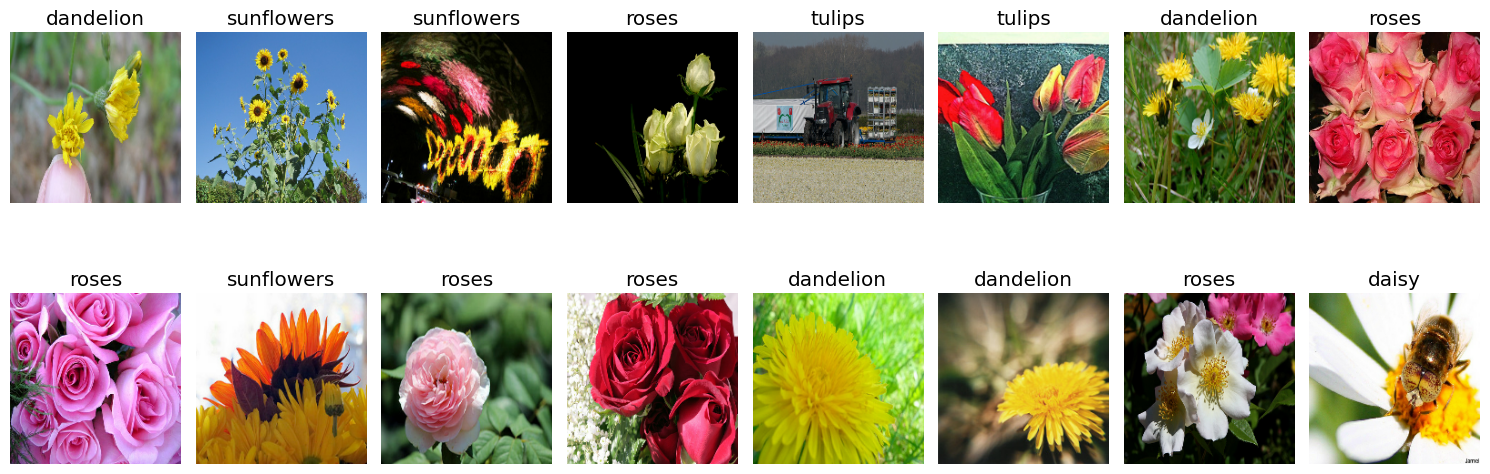

In [10]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):        
        plt.subplot(int(BATCH_SIZE/8),8,i+1)        
        plt.grid(False)        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float        
        plt.title(class_names[labels[i]])        
        plt.axis("off")
    
    plt.tight_layout()    
    plt.show()

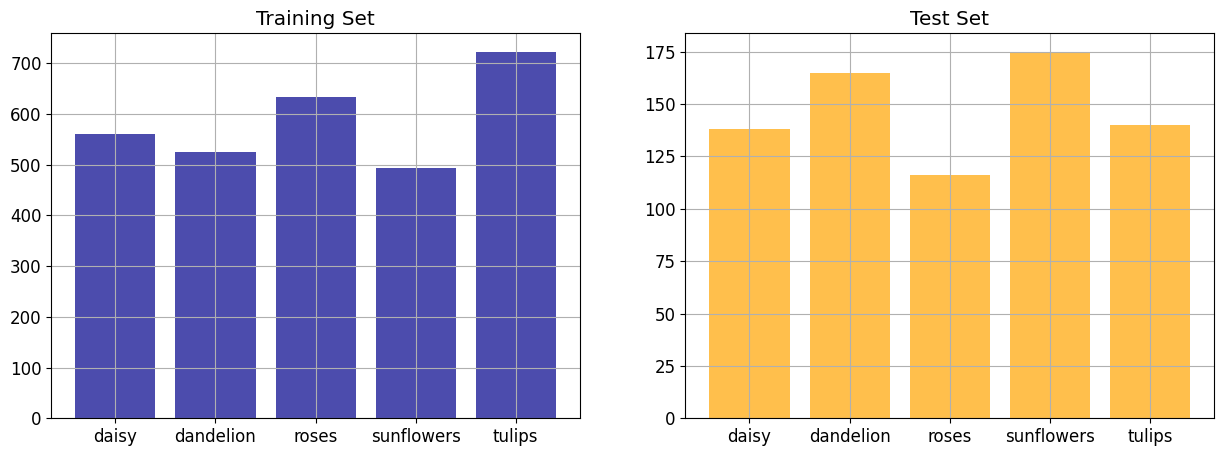

In [11]:
fn_plot_label(train_ds, test_ds)

In [12]:
images[i].shape

TensorShape([188, 188, 3])

In [13]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

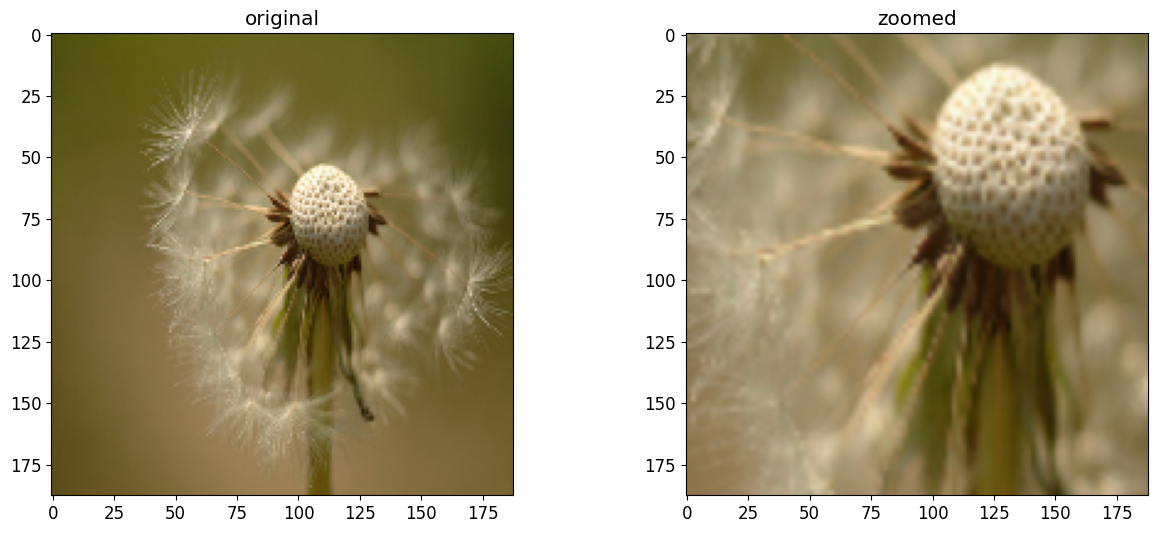

In [14]:
#Random Zoom
layer = tf.keras.layers.RandomZoom(height_factor=(-0.5,-0.5), width_factor=(-0.5,-0.5))

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):    
    out_images = layer(images)    
    plt.subplot(1,2,1)    
    plt.title('original')    
    plt.imshow(images[img_num].numpy().astype('uint8'))    
    plt.subplot(1,2,2)    
    plt.title('zoomed')    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

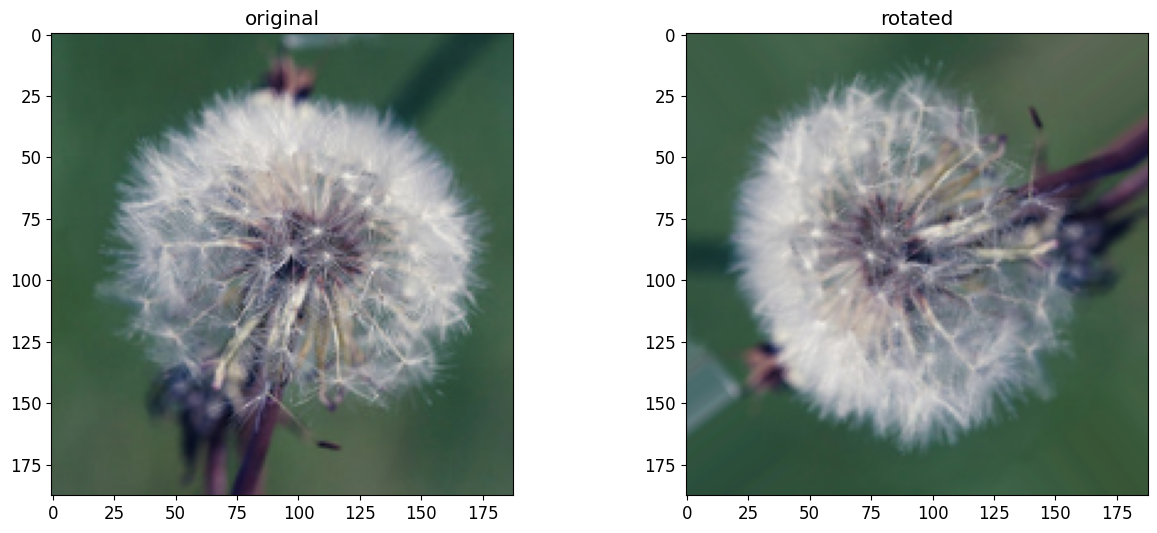

In [15]:
#Random Rotation
layer =   tf.keras.layers.RandomRotation((-1., 1.), fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):    
    out_images = layer(images)    
    plt.subplot(1,2,1)    
    plt.title('original')    
    plt.imshow(images[img_num].numpy().astype('uint8'))    
    plt.subplot(1,2,2)    
    plt.title('rotated')    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

In [16]:
# Standardize the data
# The original RGB channel values are in the [0, 255] range. Resizing has converted those values into floats. 
# Standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.
# Rescaling layer.

## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
def build_model(input_shape, n_classes):

    dor1 = 0.15
    dor2 = 0.25
    dor3 = 0.4

    krnl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
    
    model = tf.keras.Sequential([
        
        # Scaling all images between 0 and 1
        tf.keras.layers.Rescaling(1./255),
        # Data Augumentation : ---------------
        tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed=RANDOM_STATE ),   
        tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode = FILL_MODE, seed=RANDOM_STATE ),
        
        #tf.keras.layers.RandomTranslation(height_factor = (0.2,0.3), 
        #                                  width_factor= (0.2,0.3) ),
        #tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2),
        #                           width_factor=(-0.3, -0.2)),
                                 

        # Set 1 : ---------------
        tf.keras.layers.Conv2D(filters = 64,
                               kernel_initializer = krnl_init,
                               kernel_size = (3, 3),
                               padding = 'same', #  output_shape = 188, 188, 64
                               use_bias = False,
                               input_shape = input_shape ),        
        tf.keras.layers.BatchNormalization(), #  output_shape = 188, 188, 64
        tf.keras.layers.Activation('swish'),        
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 94, 94, 64
        tf.keras.layers.Dropout(dor1), #  output_shape = 94, 94, 64
        
        # Set 2 : ---------------
        tf.keras.layers.Conv2D(filters = 128,
                               kernel_initializer = krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), #  output_shape = 92, 92, 128        
        tf.keras.layers.BatchNormalization(), #  output_shape = 92, 92, 128
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 46, 46, 128
        tf.keras.layers.Dropout(dor2), #  output_shape = 46, 46, 128

        # Set 3 : ---------------
        tf.keras.layers.Conv2D(filters =256,
                               kernel_initializer = krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), #  output_shape = 44, 44, 256                                 
        tf.keras.layers.BatchNormalization(), #  output_shape = 44, 44, 256
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 22, 22, 256
        tf.keras.layers.Dropout(dor2), #  output_shape = 22, 22, 256

        # Set 4: ---------------
        tf.keras.layers.Conv2D(filters = 512,
                               kernel_initializer= krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), #  output_shape = 20, 20, 512        
        tf.keras.layers.BatchNormalization(), #  output_shape = 20, 20, 512
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 10, 10, 512
        tf.keras.layers.Dropout(dor1), #  output_shape = 10, 10, 512

        # Set 5: ---------------
        tf.keras.layers.Conv2D(filters = 1024,
                               kernel_initializer= krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), # output_shape = 8, 8, 1024        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), # output_shape = 4, 4, 1024
        tf.keras.layers.Dropout(dor1), # output_shape = 4, 4, 1024

        
        # Flatten the layers
        tf.keras.layers.Flatten(),
        
        # First Dense set
        tf.keras.layers.Dense(1024,
                              kernel_initializer = krnl_init,
                              use_bias = False),        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('swish'), 
        tf.keras.layers.Dropout(dor3),
        
        # output layer
        tf.keras.layers.Dense(n_classes,
                              kernel_initializer = krnl_init
                              )

    ])
    return model

In [18]:
num_classes = len(class_names)
model = build_model(input_shape, num_classes)

In [19]:
# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Reduction schedule for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)


checkpoint_prefix = os.path.join(checkpoint_dir, altName)

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    callbacks=[ early_callback, model_callback, lr_reduce],
                    epochs=EPOCHS)

Epoch 1/100
184/184 [==============================] - ETA: 0s - loss: 1.8854 - accuracy: 0.3832
Epoch 1: val_loss improved from inf to 2.03868, saving model to ../models/flower_photos/dropout_bn_no_bias_swish_flowers
184/184 [==============================] - 212s 1s/step - loss: 1.8854 - accuracy: 0.3832 - val_loss: 2.0387 - val_accuracy: 0.3406 - lr: 0.0100
Epoch 2/100
184/184 [==============================] - ETA: 0s - loss: 1.6925 - accuracy: 0.4479
Epoch 2: val_loss did not improve from 2.03868
184/184 [==============================] - 208s 1s/step - loss: 1.6925 - accuracy: 0.4479 - val_loss: 2.1679 - val_accuracy: 0.4114 - lr: 0.0100
Epoch 3/100
184/184 [==============================] - ETA: 0s - loss: 1.4456 - accuracy: 0.5307
Epoch 3: val_loss improved from 2.03868 to 1.71552, saving model to ../models/flower_photos/dropout_bn_no_bias_swish_flowers
184/184 [==============================] - 209s 1s/step - loss: 1.4456 - accuracy: 0.5307 - val_loss: 1.7155 - val_accuracy: 0

In [ ]:
model.summary()

In [ ]:
res_df = pd.DataFrame(history.history)
res_df

In [ ]:
fn_plot_hist(res_df)

In [ ]:
tf.train.latest_checkpoint( os.path.join(modelDir, subDir) ) 

In [ ]:
model1 = build_model(input_shape, num_classes)
model1.load_weights(tf.train.latest_checkpoint( os.path.join(modelDir, subDir) ) )

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Evaluate the model
test_loss, test_acc = model1.evaluate(test_ds, verbose=1)

In [ ]:
#yhat = model.predict(X_test, batch_size=n_batch)
yhat = model1.predict(test_ds)

In [ ]:
y_test = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
y_pred = yhat.argmax(axis = 1)
print('Accuracy score on Test Data : {:.3f}%'.format( accuracy_score(y_test, y_pred)*100))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))
disp.plot(ax = ax, cmap=plt.cm.Blues);
ax.set_xticklabels(class_names,rotation=45, ha='right');

In [ ]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take( 1 ):    
    for i in range ( BATCH_SIZE ):        
        plt.subplot(int( BATCH_SIZE / 8 ),8, i+1 )        
        plt.grid(False)        
        plt.imshow ( images[i].numpy().astype( "uint8" ) )        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))        
        plt.axis("off")
        
    plt.tight_layout()    
    plt.show()

In [ ]:
model_path = checkpoint_prefix+'.h5'
model.save(model_path, save_format='h5')

In [ ]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

In [ ]:
test_loss, test_acc = new_model.evaluate(test_ds, verbose=1)